In [43]:
## IMPORTS
import numpy as np
from numpy.polynomial.legendre import leggauss
import scipy
from scipy.io import loadmat
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import math
import pyshtools as pysh
import pandas as pd
import os

In [141]:
## PARAMETERS
rhoi=917    
rhow=1000   
a=6378100  
Me=5.972e24 
g=9.8
omega = 7.292* 10**(-5)

## rotation moments
Cmoment = 0.3307007*Me*a**2 
Amoment = 0.3296145*Me*a**2
Bmoment = Amoment

N = 64
maxdeg = N

epsilon = 1e-4
maxiter = 10
lmax=361 
lreturn=N

In [142]:
# Gauss Legendre Grid Set-up
def Legendre(n,x):
    x=np.asarray(x)
    c = np.zeros(n+1)
    c[-1]=1
    return np.polynomial.legendre.legval(x,c)


def DLegendre(n,x):
    x=np.asarray(x)
    if (n==0):
        return x*0
    elif (n==1):
        return x*0+1.0
    else:
        return (n/(x**2-1.0))*(x*Legendre(n,x)-Legendre(n-1,x))

def GaussLegendreWeights(N,x):
    W=[]
    xis=x
    W=2.0/( (1.0-xis**2)*(DLegendre(N,xis)**2) )
    return W
    
x = scipy.special.roots_legendre(N)[0]
w = GaussLegendreWeights(N,x);

x_GL = np.arccos(x)*180/np.pi - 90; 
lon_GL = np.linspace(0,360,2*N+1);
lon_GL = lon_GL[0:-1];
lon_out,lat_out = np.meshgrid(lon_GL,x_GL);

(64, 128)


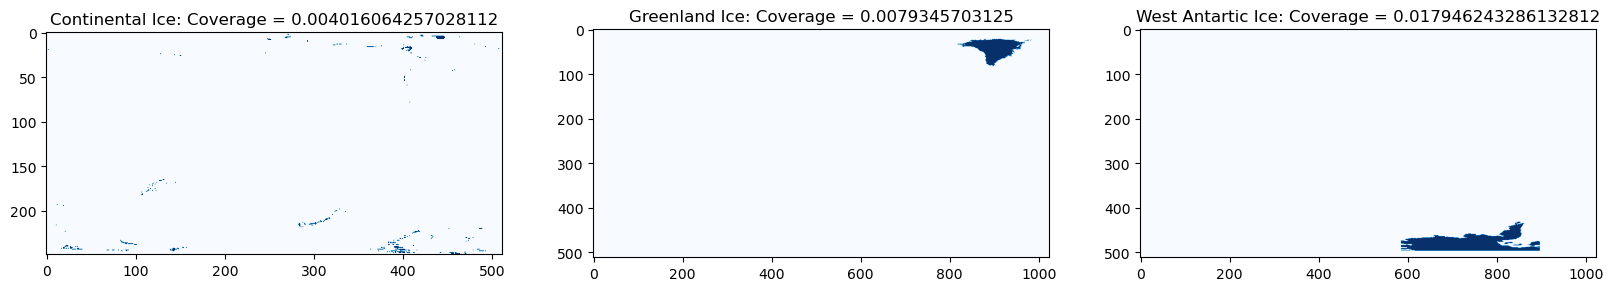

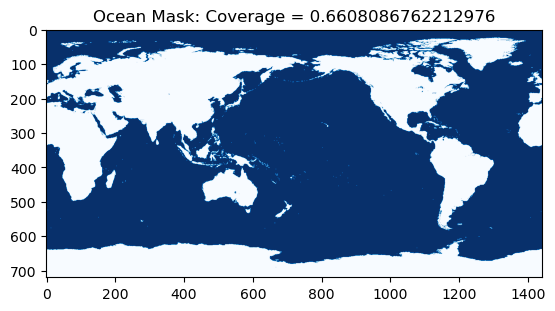

In [143]:
## MASKS 

# Mat1: Greenland and Wais
mat = loadmat("data/ice_masks.mat")
lon_mask = np.array(mat["lon_mask"])
lat_mask = np.array(mat["lat_mask"])
Greenland_mask = np.where(np.array(mat['Greenland_mask'])>0,1,0)
WAIS_mask = np.where(np.array(mat['WAIS_mask'])>0,1,0)

# Mat2: Continental 
mat_cont = loadmat("data/cont_mask.mat")
Cont_mask = np.where(np.array(mat_cont["continental_glaciers_mask"])>0,1,0)

# Mat3: Ocean (Topographic)
mat = loadmat("data/topography.mat")
lat_topo = np.array(mat["lat_topo"])
lon_topo = np.array(mat["lon_topo"])
topo_ice = np.array(mat["topo_ice"])
x = interp2d(lon_topo, lat_topo, topo_ice)
topo_pres_plot = x(lon_out[0,:], lat_out[:,0])
print(topo_pres_plot.shape)
C = np.where(topo_ice > 0, 0, 1)

# Visualization
fig, ax = plt.subplots(1,3,figsize=(20, 100))
cm = 'Blues'
ax[0].imshow(Cont_mask,cmap=cm)
ax[0].set_title(f'Continental Ice: Coverage = {np.mean(Cont_mask)}')
ax[1].imshow(Greenland_mask,cmap=cm)
ax[1].set_title(f'Greenland Ice: Coverage = {np.mean(Greenland_mask)}')
ax[2].imshow(WAIS_mask,cmap=cm)
ax[2].set_title(f'West Antartic Ice: Coverage = {np.mean(WAIS_mask)}')
plt.savefig('plots/Ocean Mask Visual.png')
plt.show()

plt.imshow(np.flip(np.flip(C), axis=1),cmap = cm)
plt.title(f'Ocean Mask: Coverage = {np.mean(C)}')
plt.savefig('plots/Ocean Mask Visual.png')
plt.show()

In [144]:
# ELASTICITY CONSTANTS
lovenumbers=np.loadtxt('data/lovenumbers_python.txt')

k_E=lovenumbers[:,2]
h_E=lovenumbers[:,1]

l=np.zeros([2,N+1,N+1])
k_l=np.zeros([2,N+1,N+1])
h_l=np.zeros([2,N+1,N+1])
I,J,K=l.shape
for i in np.arange(0,I):
    for j in np.arange(0,J):
        for k in np.arange(0,K):
            l[i,j,k]=j
            k_l[i,j,k]=k_E[j]
            h_l[i,j,k]=h_E[j]

E_l=1+k_l-h_l
T_l=(4*np.pi*a**3)/(Me*(2*l+1))

# Set-up grid and variables pysh uses for the spherical harmonic transform
zero, w = pysh.expand.SHGLQ(lmax)                 # Transform variables
latglq, longlq = pysh.expand.GLQGridCoord(lmax)   # Transform grid

# GL and spherical harmonic ocean function
y = interp2d(lon_topo, lat_topo, topo_ice)
topo_pres = y(longlq, latglq)
C = np.where(topo_pres > 0, 0, 1)
c_lm = pysh.expand.SHExpandGLQC(C,w,zero,norm=1,csphase=1,lmax_calc=lreturn)


# Re-calculate C on correct grid
topoglq2 = y(longlq,latglq)
cilm_topo = pysh.expand.SHExpandGLQC(topoglq2,w,zero,norm=1,csphase=1,lmax_calc=lreturn)
zero_down, w_down = pysh.expand.SHGLQ(lreturn)
topo_down_grid = pysh.expand.MakeGridGLQC(cilm_topo,zero_down,lmax=lreturn,norm=1,csphase=1,lmax_calc=lreturn)
topo_down = np.sign(topo_down_grid).real*np.abs(topo_down_grid)
C=np.copy(topo_down)
C[C>0]=0
C[C<0]=1

In [145]:
def fingerprint(ice_sheet,eustatic = .01, rotation=True): 

    # ICE MASKS
    if str(ice_sheet)=='CONT':
        mat = loadmat("data/cont_mask.mat")
        lon_mask = np.array(mat["lon_mask"])
        lon_mask = lon_mask[0,:]
        lat_mask = np.array(mat["lat_mask"])
        lat_mask = lat_mask[:,0]
        ice_mask=np.array(mat["continental_glaciers_mask"])
    else:
        mat = loadmat("data/ice_masks.mat")
        lon_mask = np.array(mat["lon_mask"])
        lat_mask = np.array(mat["lat_mask"])
        ice_mask=np.array(mat[str(ice_sheet)]) 
    
    # GL
    x=interp2d(lon_mask,lat_mask,ice_mask)
    ice_mask_interp = x(longlq, latglq)
    ice_mask_interp[ice_mask_interp<0]=0
    ice_mask_interp[ice_mask_interp>0]=1
    
    # SPHERICAL HARMONICS
    ice_mask_lm = pysh.expand.SHExpandGLQC(ice_mask_interp,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

    # INITIAL GUESSES
    # pseudo-iteration
    area_ocean = c_lm[0][0,0].real
    area_ice = ice_mask_lm[0][0,0].real
    delta_I = -(eustatic*rhow* area_ocean)/(rhoi*area_ice) * ice_mask_interp 
    delta_I_lm = pysh.expand.SHExpandGLQC(delta_I,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

    delta_S = -rhoi/rhow * delta_I_lm[0][0,0]/c_lm[0][0,0]*C
    delta_S_lm = pysh.expand.SHExpandGLQC(delta_S,w,zero,norm=1,csphase=1,lmax_calc=lreturn) 

    # ITERATIVE LOOP
    for i in np.arange(1,maxiter):
        # DELTA SL
        temp =  rhoi* delta_I_lm+rhow*delta_S_lm 
        if rotation:
            L21 = rhoi*delta_I_lm[0,1,0] + rhow*delta_S_lm[0,1,0]
            G21 = 4*np.pi*a**3 * g/(5*Me)*L21

            I13 = Me*a/g*np.sqrt(10/3)*np.real(G21)
            I23 = -Me*a/g*np.sqrt(10/3)*np.imag(G21)

            m1 = 1/(Cmoment-Amoment)*I13
            m2 = 1/(Cmoment-Bmoment)*I23

            Lambda21 = a**2 * omega**2 /(np.sqrt(30))*(complex(m1,-m2))

            Lambda2m1 = -np.conj(Lambda21)

            rotations21 = E_l/g * Lambda21
            rotations2m1 = E_l/g * Lambda2m1
            temp[0,1,0] = temp[0,1,0] + rotations21[0,1,0]
            temp[1,1,0] = temp[1,1,0] + rotations2m1[1,1,0]
            
        delta_SL = pysh.expand.MakeGridGLQC((temp*T_l*E_l),zero_down,lmax=lreturn,norm=1,csphase=1,lmax_calc=lreturn) 
        
        # RO 
        delta_RO = delta_SL*C 
        delta_RO_lm = pysh.expand.SHExpandGLQC(delta_RO,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

        # EUSTATIC 
        delta_phi_g = - rhoi/rhow* delta_I_lm[0][0,0]/c_lm[0][0,0] - delta_RO_lm[0][0,0]/c_lm[0][0,0]
        
        # DELTA S
        delta_S_new = (delta_SL+delta_phi_g)*C # todo
        delta_S_lm_new =pysh.expand.SHExpandGLQC(delta_S_new,w,zero,norm=1,csphase=1,lmax_calc=lreturn) 

        # CONVERGENCE?
        chi = np.max(np.abs(delta_S_new - delta_S))
        if chi < epsilon:
            print('Converged after ', str(i), ' iterations. Chi was ', str(np.real(chi)))
            print("")
            break

        delta_S = np.copy(delta_S_new) 
        delta_S_lm = np.copy(delta_S_lm_new)

    fingerprint = delta_SL+delta_phi_g 
    
    return fingerprint.real

In [151]:
GrIS_fingerprint = fingerprint("Greenland_mask")
WAIS_fingerprint = fingerprint("WAIS_mask")
CONT_fingerprint = fingerprint("CONT")

Converged after  5  iterations. Chi was  2.1069612872600188e-05

Converged after  4  iterations. Chi was  9.940291038342854e-05

Converged after  4  iterations. Chi was  4.3294563296214505e-05



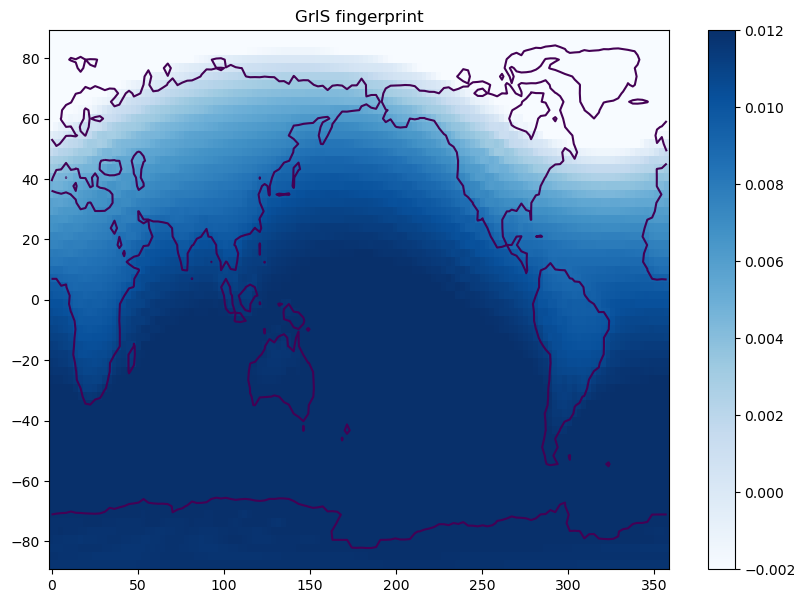

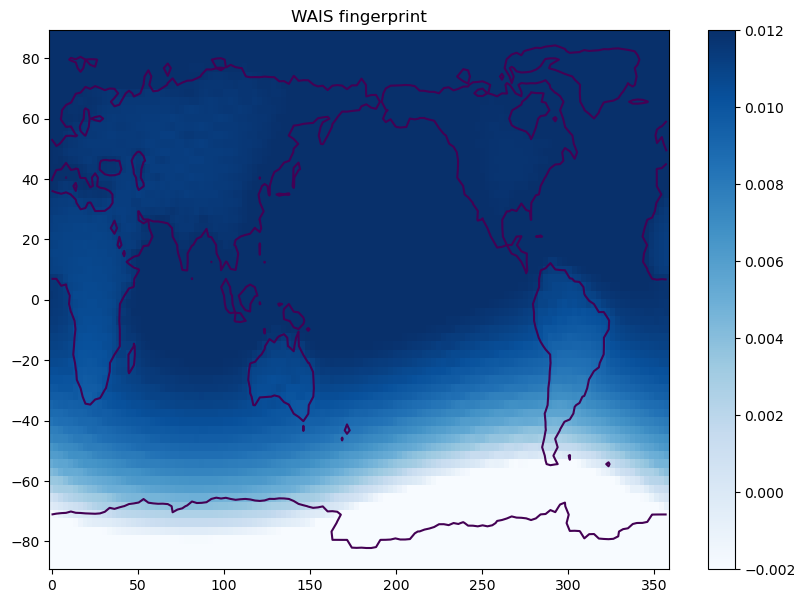

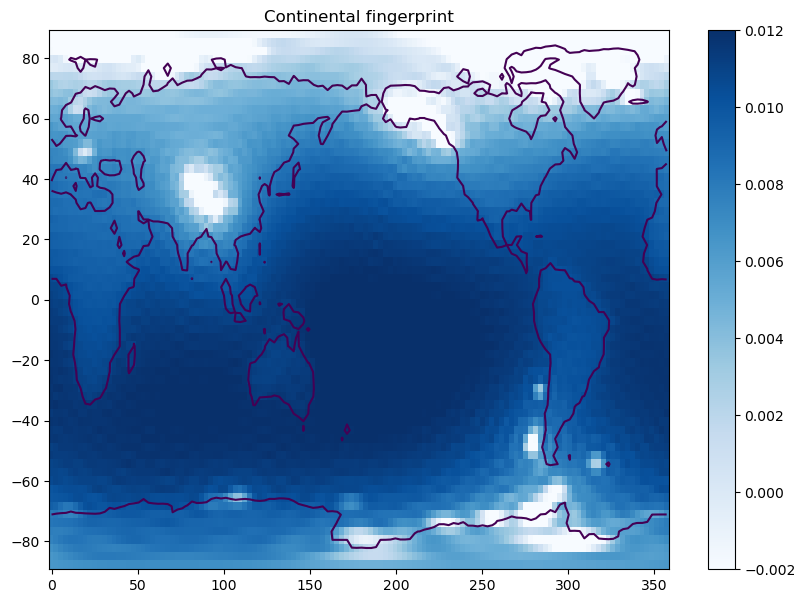

In [147]:
## Plot the Fingerprints

# GrIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(GrIS_fingerprint.real[0:N,0:2*N])), vmin=-0.002, vmax=.012,cmap = cm) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])
plt.title('GrIS fingerprint')
plt.savefig('plots/GrIS_fp.png')
plt.show()

# WAIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(WAIS_fingerprint.real[0:N,0:2*N])), vmin=-0.002, vmax=.012,cmap = cm) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])
plt.plot()
plt.title('WAIS fingerprint')
plt.savefig('plots/WAIS_fp.png')
plt.show()

# CONT
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(CONT_fingerprint.real[0:N,0:2*N])), vmin=-0.002, vmax=.012,cmap = cm) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])
plt.plot()
plt.title('Continental fingerprint')
plt.savefig('plots/Cont_fp.png')
plt.show()

In [51]:
# IPCC PROJECTIONS
# todo: IPCC scenarios

RCP_26 = [0.06,0.11,0.11]
RCP_45 = [0.08,0.11,0.11]
RCP_85 = [0.13,0.12,0.12]

In [52]:
def sea_level(RCP):
    GrIS_fingerprint = fingerprint("Greenland_mask", eustatic = RCP[0])
    WAIS_fingerprint = fingerprint("WAIS_mask", eustatic = RCP[1])
    CONT_fingerprint = fingerprint("CONT", eustatic = RCP[2])
    sea_level_print = GrIS_fingerprint+WAIS_fingerprint+CONT_fingerprint
    return sea_level_print

In [148]:
RCP_26_SL = sea_level(RCP_26)
RCP_45_SL = sea_level(RCP_45)
RCP_85_SL = sea_level(RCP_85)
RCP_SLs = [RCP_26_SL, RCP_45_SL, RCP_85_SL]
TITLES = ['RCP 26', 'RCP 45', 'RCP 85']

Converged after  6  iterations. Chi was  2.78374596656486e-05

Converged after  6  iterations. Chi was  4.822687654275348e-05

Converged after  5  iterations. Chi was  8.161206157400458e-05

Converged after  6  iterations. Chi was  3.7116612887591605e-05

Converged after  6  iterations. Chi was  4.822687654275348e-05

Converged after  5  iterations. Chi was  8.161206157400458e-05

Converged after  6  iterations. Chi was  6.031449594233462e-05

Converged after  6  iterations. Chi was  5.261113804662376e-05

Converged after  5  iterations. Chi was  8.903133989893175e-05



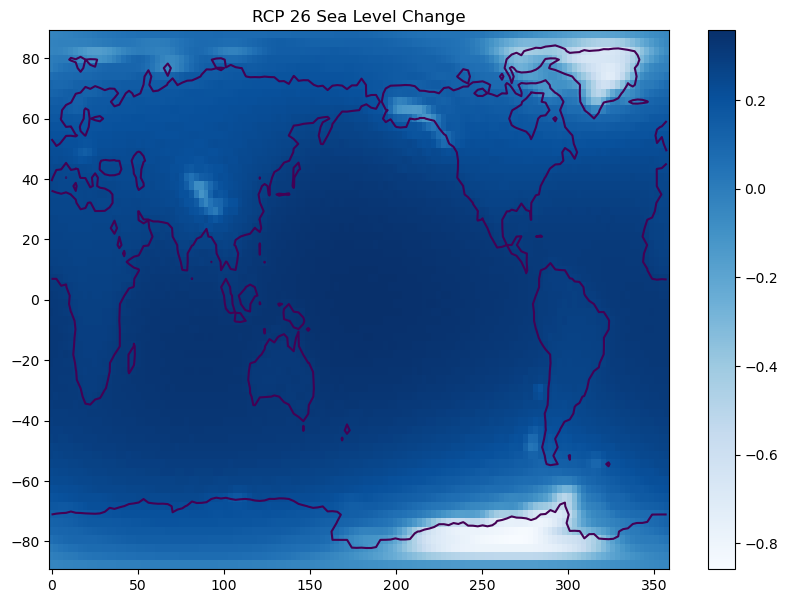

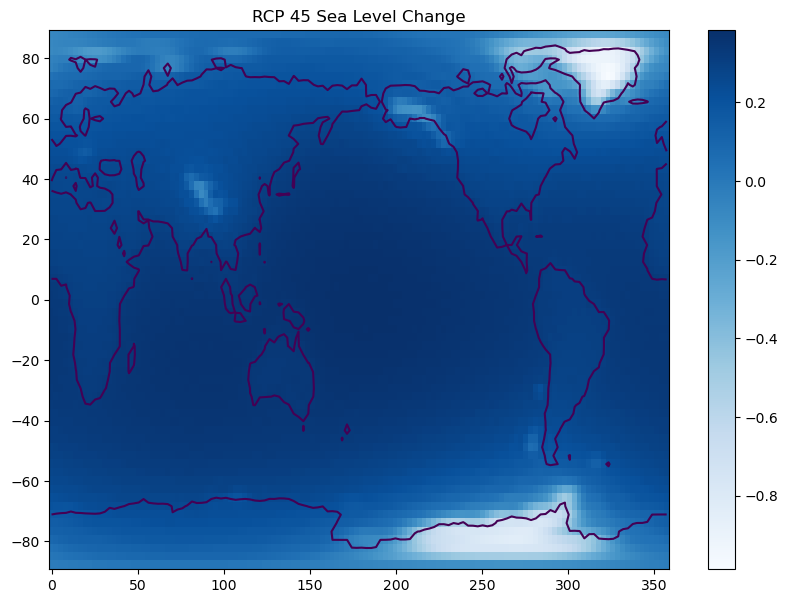

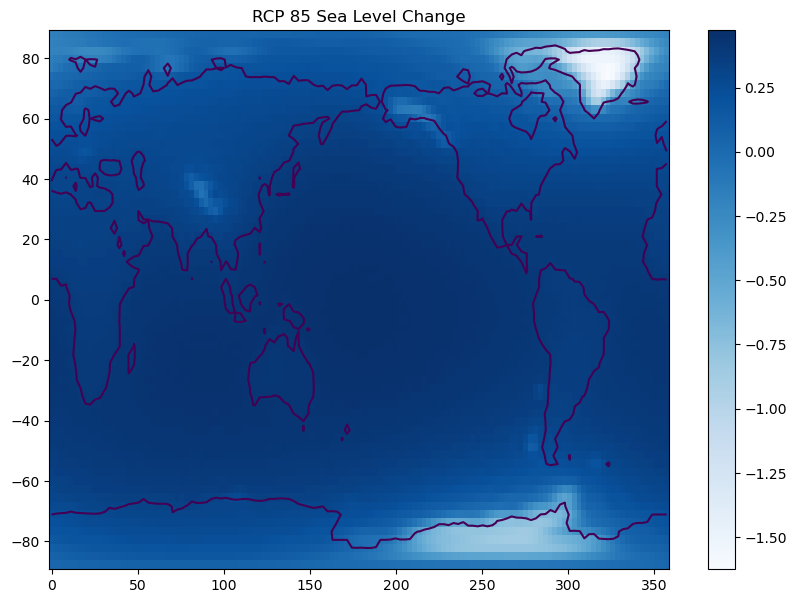

In [149]:
for n in range(3):
    RCP_SL = RCP_SLs[n]
    fig = plt.figure(figsize=(10,7))
    plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(RCP_SL.real[0:N,0:2*N])),cmap = cm) #x,y,c 
    plt.colorbar()
    plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])
    plt.plot()
    plt.title(f'{TITLES[n]} Sea Level Change')
    plt.savefig(f'plots/{TITLES[n]}.png')
    plt.show()

In [138]:
GrIS_fingerprint_rot = fingerprint_rotation("Greenland_mask")
WAIS_fingerprint_rot = fingerprint_rotation("WAIS_mask")
CONT_fingerprint_rot = fingerprint_rotation("CONT")

(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
Converged after  5  iterations. Chi was  2.1069612872600188e-05

(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
Converged after  4  iterations. Chi was  9.940291038342854e-05

(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
(2, 65, 65)
Converged after  4  iterations. Chi was  4.3294563296214505e-05



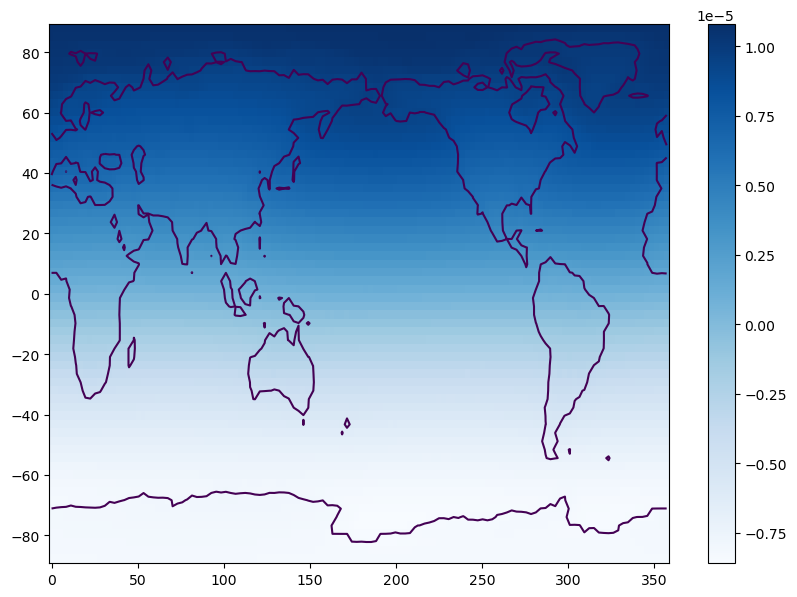

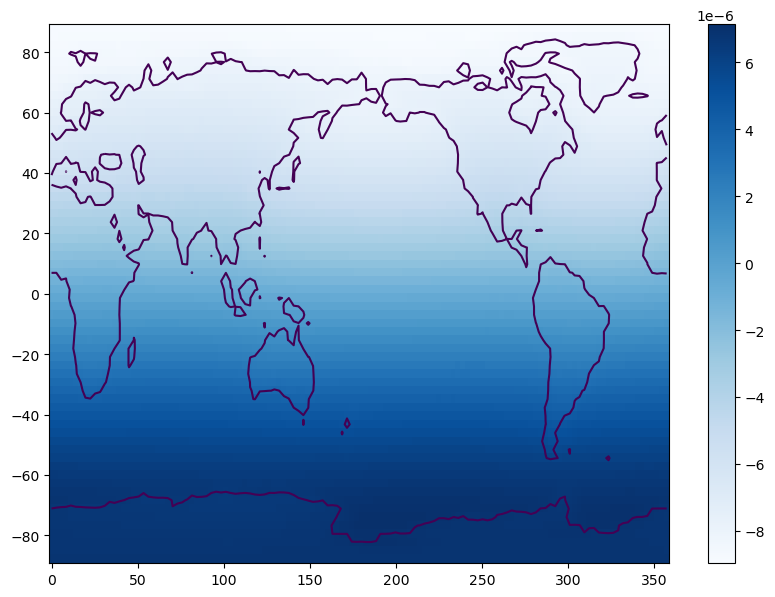

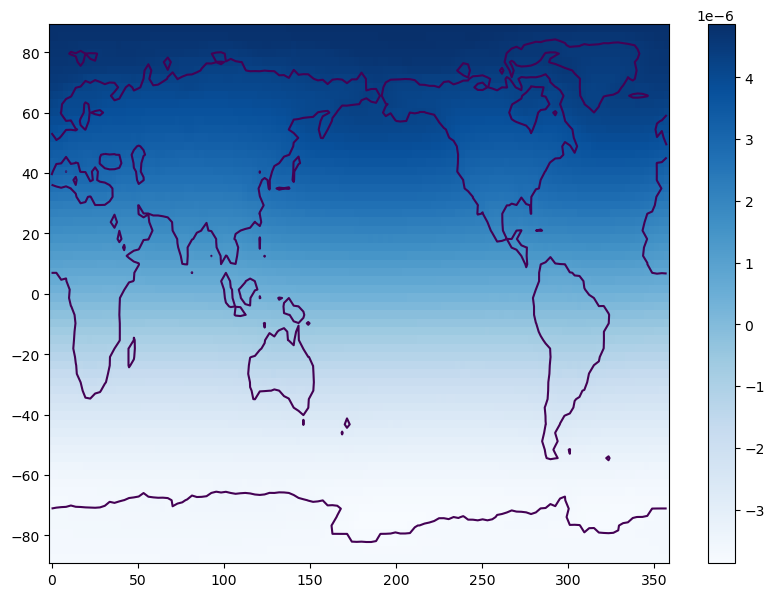

In [139]:
## Plot the Fingerprints

# GrIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(GrIS_fingerprint_rot[0:N,0:2*N]-GrIS_fingerprint[0:N,0:2*N])),cmap = cm) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])

# GrIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(WAIS_fingerprint_rot[0:N,0:2*N]-WAIS_fingerprint[0:N,0:2*N])),cmap = cm) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])

# GrIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(CONT_fingerprint_rot[0:N,0:2*N]-CONT_fingerprint[0:N,0:2*N])),cmap = cm) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres_plot)),levels=[0])


In [140]:
np.mean(GrIS_fingerprint_rot[0:N,0:2*N]-GrIS_fingerprint[0:N,0:2*N])
# print(np.mean(WAIS_fingerprint_rot[0:N,0:2*N]-WAIS_fingerprint[0:N,0:2*N]))
# print(np.mean(CONT_fingerprint_rot[0:N,0:2*N]-CONT_fingerprint[0:N,0:2*N]))

7.416056880895137e-07